<a href="https://colab.research.google.com/github/zia207/r-colab/blob/main/NoteBook/Advance_Regression/02-02-03-regularized-glm-multinominal-r.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![alt text](http://drive.google.com/uc?export=view&id=1bLQ3nhDbZrCCqy_WCxxckOne2lgVvn3l)

# 3. Regularized Multinomial Logistic Model

This tutorial will explore how to perform regularized multinomial logistic regression in R. We will cover both the manual approach—building the model from scratch—and using the popular {glmnet} package. The {glmnet} package is widely used for fitting generalized linear models with elastic net regularization and offers efficient algorithms for solving penalized regression problems. By the end of this tutorial, you will thoroughly understand how to fit regularized multinomial logistic regression models in R, both by manually implementing the model and utilizing the efficient {glmnet} package for regularized model fitting. Mastering regularized multinomial logistic regression is an essential skill for any data scientist or statistician, whether you are working with high-dimensional data or aiming to improve the interpretability of your models.

## Overview

Multinomial Logistic Regression (MLR) is an extension of binary logistic regression used when the dependent variable $y$ is categorical with more than two levels (e.g., $C$ classes, $y \in \{1, 2, \dots, C\}$). Regularization is added to the optimization process to prevent overfitting by penalizing large coefficients. To prevent overfitting, regularization is introduced by adding a penalty term to the likelihood function.

The common regularization techniques are:

***Ridge Regularization (L2)***

Adds a penalty proportional to the square of the coefficients:

$$ \mathcal{R}_{\text{ridge}} = \lambda \sum_{c=1}^C \|\mathbf{\beta}_c\|_2^2 $$

where $\lambda > 0$$ is the regularization strength. The objective becomes:

$$ \ell_{\text{ridge}}(\beta) = \ell(\beta) - \lambda \sum_{c=1}^C \|\mathbf{\beta}_c\|_2^2 $$


***Lasso Regularization (L1)***

Adds a penalty proportional to the absolute value of the coefficients:

$$ \mathcal{R}_{\text{lasso}} = \lambda \sum_{c=1}^C \|\mathbf{\beta}_c\|_1 $$

The objective becomes:

$$ \ell_{\text{lasso}}(\beta) = \ell(\beta) - \lambda \sum_{c=1}^C \|\mathbf{\beta}_c\|_1 $$

***Elastic Net Regularization***

Combines L1 and L2 penalties:

$$ \mathcal{R}_{\text{elastic}} = \lambda_1 \sum_{c=1}^C \|\mathbf{\beta}_c\|_1 + \lambda_2 \sum_{c=1}^C \|\mathbf{\beta}_c\|_2^2 $$

The objective becomes:

$$ \ell_{\text{elastic}}(\beta) = \ell(\beta) - \lambda_1 \sum_{c=1}^C \|\mathbf{\beta}_c\|_1 - \lambda_2 \sum_{c=1}^C \|\mathbf{\beta}_c\|_2^2 $$


In Optimization Process, the parameters are estimated by solving:

$$ \arg \max_{\beta} \ell(\beta) - \mathcal{R}(\beta $$

where $\mathcal{R}(\beta)$ is the chosen regularization term.

Compute probabilities using the softmax function. Assign class $c$ with the highest probability:


$$ \hat{y} = \arg \max_{c} P(y = c \mid \mathbf{x}) $$
    
Use metrics like accuracy, cross-entropy loss, or confusion matrix to evaluate performance.


## Install rpy2

In [2]:
!pip uninstall rpy2 -y
!pip install rpy2==3.5.1
%load_ext rpy2.ipython

Found existing installation: rpy2 3.4.2
Uninstalling rpy2-3.4.2:
  Successfully uninstalled rpy2-3.4.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.7/201.7 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for rpy2: filename=rpy2-3.5.1-cp311-cp311-linux_x86_64.whl size=314972 sha256=85c8023fcc3956e160c3e0be3d71145f0e9eed58274bf7eb3d0dd3cfd53ecf7a
  Stored in directory: /root/.cache/pip/wheels/e9/55/d1/47be85a5f3f1e1f4d1e91cb5e3a4dcb40dd72147f184c5a5ef
Successfully built rpy2


## Mount Google Drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Regularized Multinomial Logistic Regression from Scratch

Fitting a regularized multinomial logistic regression in R without using external packages can be achieved by manually implementing the necessary steps, as R does not natively provide multinomial logistic regression with regularization in base functions. Here's a comprehensive guide to perform this task:

### Synthetic Data Generation

We will generate a synthetic dataset with three classes and multiple predictors.

In [ ]:
%%R
# Set seed for reproducibility
set.seed(42)

# 1. Generate synthetic data
n <- 300  # Number of observations
p <- 10   # Number of predictors
k <- 3    # Number of classes

# Generate predictors
X <- matrix(rnorm(n * p), n, p)

# Generate coefficients
beta <- matrix(rnorm(p * (k - 1)), p, k - 1)

# Compute linear predictors and probabilities
eta <- cbind(0, X %*% beta)  # Linear predictors for k-1 classes
prob <- exp(eta) / rowSums(exp(eta))  # Convert to probabilities
y <- apply(prob, 1, function(x) sample(1:k, 1, prob = x))  # Multinomial response

data <- data.frame(y = as.factor(y), X)
head(data)

  y         X1           X2         X3          X4          X5         X6
1 3  1.3709584 -0.004620768 -0.2484829  0.94192422 -0.74651645 -0.6013830
2 1 -0.5646982  0.760242168  0.4223204 -0.24861404  0.03660612 -0.1358161
3 1  0.3631284  0.038990913  0.9876533  0.09647886  0.32330962 -0.9872728
4 3  0.6328626  0.735072142  0.8355682 -0.43393094  0.37967603  0.8319250
5 3  0.4042683 -0.146472627 -0.6605219  2.17866787  0.87655650 -0.7950595
6 2 -0.1061245 -0.057887335  1.5640695 -2.95877962  0.93338799  0.3404646
          X7          X8          X9        X10
1 -1.2213334 -0.58693858  1.32750456 -0.5446893
2 -0.4529860  0.92697573 -0.60083583 -0.4345330
3 -0.7023199 -0.06540585  0.05650686 -0.1408452
4 -0.6743804 -0.93711176 -0.53107629  1.7581413
5 -2.3030232 -0.63385943 -0.08089878 -0.8301414
6 -0.1493329 -0.57522429  0.16075559  0.5144278


### Cross-validation setup and Regularization

Create a 5-fold cross-validation setup and define the hyperparameters for regularization.

In [ ]:
%%R
# 2. Cross-validation setup
folds <- sample(1:5, n, replace = TRUE)  # 5-fold cross-validation
alphas <- seq(0, 1, by = 0.1)  # Elastic net mixing
lambdas <- 10^seq(-4, 1, length = 10)  # Regularization strengths

### Create Loss Functions and Optimization
  
Define the loss functions for Ridge, Lasso, and Elastic Net regularization. The loss functions compute the negative log-likelihood of the multinomial logistic regression model with the penalty term.

In [ ]:
%%R
# 3. Loss functions for regularized multinomial logistic regression
ridge_loss <- function(beta_vec, X, y, lambda, k) {
  n <- nrow(X)
  p <- ncol(X)
  beta <- matrix(beta_vec, p, k - 1)

  # Compute linear predictors and probabilities
  eta <- cbind(0, X %*% beta)
  prob <- exp(eta) / rowSums(exp(eta))

  # Multinomial negative log-likelihood
  log_lik <- -sum(log(prob[cbind(1:n, as.numeric(y))]))

  # Ridge penalty
  ridge_penalty <- lambda * sum(beta^2)

  return(log_lik + ridge_penalty)
}

lasso_loss <- function(beta_vec, X, y, lambda, k) {
  n <- nrow(X)
  p <- ncol(X)
  beta <- matrix(beta_vec, p, k - 1)

  # Compute linear predictors and probabilities
  eta <- cbind(0, X %*% beta)
  prob <- exp(eta) / rowSums(exp(eta))

  # Multinomial negative log-likelihood
  log_lik <- -sum(log(prob[cbind(1:n, as.numeric(y))]))

  # Lasso penalty
  lasso_penalty <- lambda * sum(abs(beta))

  return(log_lik + lasso_penalty)
}

elastic_net_loss <- function(beta_vec, X, y, lambda, alpha, k) {
  n <- nrow(X)
  p <- ncol(X)
  beta <- matrix(beta_vec, p, k - 1)

  # Compute linear predictors and probabilities
  eta <- cbind(0, X %*% beta)
  prob <- exp(eta) / rowSums(exp(eta))

  # Multinomial negative log-likelihood
  log_lik <- -sum(log(prob[cbind(1:n, as.numeric(y))]))

  # Elastic net penalty
  ridge_penalty <- (1 - alpha) * lambda * sum(beta^2)
  lasso_penalty <- alpha * lambda * sum(abs(beta))

  return(log_lik + ridge_penalty + lasso_penalty)
}

# Gradient descent optimization for Ridge, Lasso, and Elastic Net
optimize_model <- function(X, y, lambda, alpha =NULL,  k, loss_function) {
  p <- ncol(X)
  beta_init <- rnorm(p * (k - 1))

  # Pass alpha only for Elastic Net
  if (is.null(alpha)) {
    optim_res <- optim(beta_init, loss_function, X = X, y = y, lambda = lambda, k = k, method = "BFGS")
  } else {
    optim_res <- optim(beta_init, loss_function, X = X, y = y, lambda = lambda, alpha = alpha, k = k, method = "BFGS")
  }

  return(matrix(optim_res$par, p, k - 1))
}

### Hyperparameter Selection via Cross-Validation

Perform hyperparameter selection via cross-validation to find the best model and hyperparameters.  

In [ ]:
%%R
# 4. Hyperparameter selection via Cross-Validation
cv_results <- data.frame(Model = character(), alpha = numeric(), lambda = numeric(), log_loss = numeric())

# Ridge, Lasso, and Elastic Net models
models <- c("Ridge", "Lasso", "ElasticNet")

for (model in models) {
  for (alpha in alphas) {
    for (lambda in lambdas) {
      log_losses <- c()
      for (fold in 1:5) {
        train_idx <- which(folds != fold)
        test_idx <- which(folds == fold)

        # Train model
        if (model == "Ridge") {
          beta <- optimize_model(X[train_idx, ], y[train_idx], lambda, alpha = NULL, k, ridge_loss)
        } else if (model == "Lasso") {
          beta <- optimize_model(X[train_idx, ], y[train_idx], lambda, alpha = NULL, k, lasso_loss)
        } else if (model == "ElasticNet") {
          beta <- optimize_model(X[train_idx, ], y[train_idx], lambda, alpha, k, elastic_net_loss)
        }

        # Predict on test data
        eta_test <- cbind(0, X[test_idx, ] %*% beta)
        prob_test <- exp(eta_test) / rowSums(exp(eta_test))

        # Compute log-loss
        log_loss <- -mean(log(prob_test[cbind(1:length(test_idx), as.numeric(y[test_idx]))]))
        log_losses <- c(log_losses, log_loss)
      }
      cv_results <- rbind(cv_results, data.frame(Model = model, alpha = alpha, lambda = lambda, log_loss = mean(log_losses)))
    }
  }
}

# Best model and hyperparameters
best_params <- cv_results[which.min(cv_results$log_loss), ]
best_model <- best_params$Model
best_alpha <- best_params$alpha
best_lambda <- best_params$lambda
best_lambda
best_alpha

[1] 0.6


### Fit ridge, lasso, and elastic net models

Fit the final models using the best hyperparameters obtained from cross-validation.

In [ ]:
%%R
ridge_beta<- optimize_model(X, y, best_lambda, alpha = NULL, k, ridge_loss)
lasso_beta<- optimize_model(X, y, best_lambda, alpha = NULL, k, lasso_loss)
elastic_net_beta <- optimize_model(X, y, best_lambda, best_alpha, k, elastic_net_loss)


### Moodel Evaluation

In [ ]:
%%R
# ealstic net
# 6. Model Evaluation: Confusion Matrix, Accuracy, Cross-Entropy
eta <- cbind(0, X %*% elastic_net_beta)
prob <- exp(eta) / rowSums(exp(eta))
predictions <- apply(prob, 1, which.max)

# Confusion matrix
conf_mat <- table(Predicted = predictions, Actual = y)

# Overall accuracy
accuracy <- sum(diag(conf_mat)) / n

# In-class accuracy
in_class_acc <- diag(conf_mat) / rowSums(conf_mat)

# Cross-entropy
cross_entropy <- -mean(log(prob[cbind(1:n, as.numeric(y))]))

# Output results
list(
  Best_Model = best_model,
  Confusion_Matrix = conf_mat,
  Overall_Accuracy = accuracy,
  In_Class_Accuracy = in_class_acc,
  Cross_Entropy = cross_entropy
)


$Best_Model
[1] "ElasticNet"

$Confusion_Matrix
         Actual
Predicted  1  2  3
        1 77 13 10
        2 14 75  9
        3 15 10 77

$Overall_Accuracy
[1] 0.7633333

$In_Class_Accuracy
        1         2         3 
0.7700000 0.7653061 0.7549020 

$Cross_Entropy
[1] 0.5188962



## Regularized Multinomial Logistic Regression in R

In R, you can perform multinomial logistic regression using the {glmnet} package, which fits a generalized linear model via penalized maximum likelihood. {glmnet} supports ridge regression, lasso regression, and elastic net for various types of generalized linear models, including multinomial logistic regression.

-   The response variable y must be a factor for multinomial regression.
-   The `family = "multinomial"` argument ensures that the model performs multinomial logistic regression.
-   `glmnet` handles both Lasso (`alpha = 1`) and Ridge (`alpha = 0`) penalties, or you can use an Elastic Net combination by setting `0 < alpha < 1`.

In this tutorial, we will demonstrate how to perform regularized multinomial logistic regression in R using the {glmnet} package. We will use the `health_insurance` data set, which contains information about individuals' choice of health insurance products based on their


### Install Required R Packages

In [4]:
%%R
packages <- c('tidyverse',
     'plyr',
		 'rstatix',
		 'ggeffects',
		 'patchwork',
		 'Metrics',
		 'glmnet'
	  	)

In [ ]:
%%R
# Install missing packages
new.packages <- packages[!(pacakges %in% installed.packages(lib='drive/My Drive/R/')[,"Package"])]
if(length(new.packages)) install.packages(new.packages, lib='drive/My Drive/R/')

In [5]:
%%R
# set library path
.libPaths('drive/My Drive/R')
# Verify installation
cat("Installed packages:\n")
print(sapply(packages, requireNamespace, quietly = TRUE))

Installed packages:
tidyverse      plyr   rstatix ggeffects patchwork   Metrics    glmnet 
     TRUE      TRUE      TRUE      TRUE      TRUE      TRUE      TRUE 


### Load R Packages

In [6]:
%%R
# set library path
.libPaths('drive/My Drive/R')
# Load packages with suppressed messages
invisible(lapply(packages, function(pkg) {
  suppressPackageStartupMessages(library(pkg, character.only = TRUE))
}))
# Check loaded packages
cat("Successfully loaded packages:\n")
print(search()[grepl("package:", search())])# Check loaded packageswer)

Successfully loaded packages:
 [1] "package:glmnet"    "package:Matrix"    "package:Metrics"  
 [4] "package:patchwork" "package:ggeffects" "package:rstatix"  
 [7] "package:plyr"      "package:lubridate" "package:forcats"  
[10] "package:stringr"   "package:dplyr"     "package:purrr"    
[13] "package:readr"     "package:tidyr"     "package:tibble"   
[16] "package:ggplot2"   "package:tidyverse" "package:tools"    
[19] "package:stats"     "package:graphics"  "package:grDevices"
[22] "package:utils"     "package:datasets"  "package:methods"  
[25] "package:base"     


### Data

In this tutorial, we will be using [health_insurance data](http://peopleanalytics-regression-book.org/data/health_insurance.csv).

The health_insurance data set consists of the following fields:

-   `product`: The choice of product of the individual — A, B or C
-   `age`: The age of the individual when they made the choice
-   `gender`: The gender of the individual as stated when they made the choice
-   `household`: The number of people living with the individual in the same household at the time of the choice
-   `position_level`: Position level in the company at the time they made the choice, where 1 is is the lowest and 5 is the highest
-   `absent`: The number of days the individual was absent from work in the year prior to the choice

Full data set is available for download can download from my [Dropbox](https://www.dropbox.com/scl/fi/hz4smnf3okszutoujewc9/health_insurance.csv?rlkey=7z5wahrnyjye6fggwr2gu8dmm&dl=0) or from my [Github](https://github.com/zia207/r-colab/tree/main/Data/Regression_analysis) accounts.

In [ ]:
%%R
mf<-read_csv("https://github.com/zia207/r-colab/raw/main/Data/Regression_analysis/health_insurance.csv")
# Convert to factor
mf$product <- as.factor(mf$product)
mf$gender <- as.factor(mf$gender)
# Split data
seeds = 11076
tr_prop = 0.70
# training data (70% data)
train= ddply(mf,.(product, gender ),
                 function(., seed) { set.seed(seed); .[sample(1:nrow(.), trunc(nrow(.) * tr_prop)), ] }, seed = 101)
test = ddply(mf, .(product , gender),
            function(., seed) { set.seed(seed); .[-sample(1:nrow(.), trunc(nrow(.) * tr_prop)), ] }, seed = 101)
print(prop.table(table(train$product)))
print(prop.table(table(test$product)))

Rows: 1448 Columns: 6
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): product, gender
dbl (4): age, household, position_level, absent

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.

        A         B         C 
0.3405941 0.3158416 0.3435644 

        A         B         C 
0.3401826 0.3150685 0.3447489 


### Create x and y

You need to create two objects:

-   `y` for storing the outcome variable
-   `x` for holding the predictor variables. This should be created using the function model.matrix() allowing to automatically transform any qualitative variables (if any) into dummy variables, which is important because `glmnet()` can only take numerical, quantitative inputs. After creating the model matrix, we remove the intercept component at index = 1.


In [ ]:
%%R
# Predictor variables
x.train <- model.matrix(product~., train)[,-1]
# Outcome variable
y.train <-train$product

### Ridge Regression

#### Cross-validation for the best lambda

Now we can apply `cv.glmnet()` function for cross-validation to choose the best lambda (regularization parameter). For example, suppose we designate $α$=0 for ridge regression and specify `nlambda` as 200. This implies that the model fit will be calculated solely for 200 $λ$ values.

A special option for multinomial regression is type.multinomial, which allows the usage of a grouped lasso penalty (q=2 ) if `type.multinomial = "grouped"`. The default is `type.multinomial = "ungrouped" (q=1 ).`

In [ ]:
%%R
# cross validation
ridge.cv <- cv.glmnet(x= x.train,
                       y= y.train,
                       type.measure="deviance",
                       nfold = 5,
                       alpha=0,
                       family = "multinomial",
                       type.multinomial = "grouped",
                       nlambda=200)

Printing the resulting object gives some basic information on the cross-validation performed:

In [ ]:
%%R
print(ridge.cv)


Call:  cv.glmnet(x = x.train, y = y.train, type.measure = "deviance",      nfolds = 5, alpha = 0, family = "multinomial", type.multinomial = "grouped",      nlambda = 200) 

Measure: Multinomial Deviance 

     Lambda Index Measure      SE Nonzero
min 0.03771   200   1.139 0.01966       6
1se 0.04537   196   1.158 0.01826       6


We can plot `ridge.cv` object to see how each tested lambda value performed:

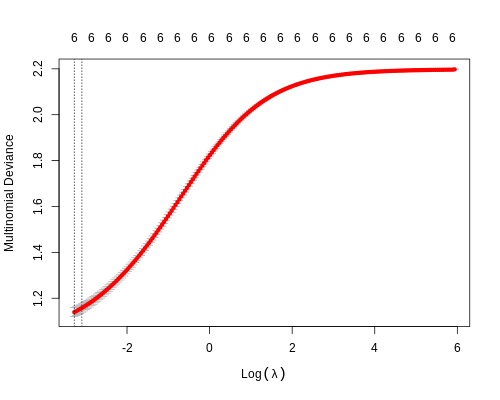

In [ ]:
%%R -w 500 -h 400
plot(ridge.cv)

The plot shows the cross-validation error based on the logarithm of lambda. The dashed vertical line on the left indicates that the optimal logarithm of lambda is around -2, which minimizes the prediction error. This lambda value will provide the most accurate model. The exact value of lambda can be viewed as follow:

In [ ]:
%%R
ridge.cv$lambda.min

[1] 0.03770618


Generally, the purpose of regularization is to balance accuracy and simplicity. This means, a model with the smallest number of predictors that also gives a good accuracy. To this end, the function `cv.glmnet()` finds also the value of lambda that gives the simplest model but also lies within one standard error of the optimal value of lambda. This value is called `lambda.1se`.

#### Fit ridge regression

Now Fit the final model with the best "lambda":

In [ ]:
%%R
# fit ridge regression
ridge.fit <-  glmnet(x= x.train,
                       y= y.train,
                       alpha=0,
                       lambda = ridge.cv$lambda.1se,
                       family = "multinomial",
                       type.multinomial = "grouped",
                       nlambda=200)

In [ ]:
%%R
# Display regression coefficients
coef(ridge.fit )

$A
6 x 1 sparse Matrix of class "dgCMatrix"
                         s0
                2.648144980
age            -0.087712433
household       0.118887896
position_level  0.125788485
genderMale      0.441857800
absent         -0.002939366

$B
6 x 1 sparse Matrix of class "dgCMatrix"
                         s0
                0.596075835
age             0.032590386
household      -0.410129801
position_level -0.106127988
genderMale     -1.027268491
absent         -0.001981378

$C
6 x 1 sparse Matrix of class "dgCMatrix"
                         s0
               -3.244220816
age             0.055122047
household       0.291241905
position_level -0.019660497
genderMale      0.585410691
absent          0.004920744



#### Prediction test data

In [ ]:
%%R
# Make predictions on the test data
x.test <- model.matrix(product~., test)[,-1]
# Outcome variable
y.test <-train$product

# Prediction
ridge.pred<-as.data.frame(test$product)
ridge.pred$Class_Pred<-ridge.fit  |>
      predict(newx = x.test, type="class")
ridge.pred <- ridge.pred |>
              dplyr::select("test$product", "Class_Pred") |>
              dplyr::rename(Obs_Class = "test$product") |>
              dplyr::rename(Pred_Class = "Class_Pred")
glimpse(ridge.pred)
# ordering the levels
ridge.pred$Obs_Class  <- ordered(ridge.pred$Obs_Class, levels = c("A", "B", "C"))
ridge.pred $Pred_Class <- ordered(ridge.pred$Pred_Class  , levels = c("A", "B", "C"))

Rows: 438
Columns: 2
$ Obs_Class  <fct> A, A, A, A, A, A, A, A, A, A, A, A, A, A, A, A, A, A, A, A,…
$ Pred_Class <chr[,1]> "A", "B", "A", "B", "B", "A", "C", "A", "A", "A", "A", …


In [ ]:
%%R
# accuracy
accuracy <- mean(ridge.pred$Obs_Class  == ridge.pred$Pred_Class)
accuracy


[1] 0.7648402


In [ ]:
%%R
# error rate
error <- mean(ridge.pred$Obs_Class != ridge.pred$Pred_Class)
error

[1] 0.2351598


In [ ]:
%%R
# confusion matrix
table(Actual = ridge.pred$Obs_Class, Predicted =ridge.pred$Pred_Class)

      Predicted
Actual   A   B   C
     A 122  17  10
     B  24 103  11
     C  22  19 110


### LASSO regression

#### Cross Validation of the best Lasso regression

We can set up our model very similarly to our ridge function. We simply need to change the `alpha`argument to 1 and do K-fold cross-validation:

In [ ]:
%%R
# cross validation
lasso.cv <- cv.glmnet(x= x.train,
                       y= y.train,
                       type.measure="mse",
                       nfold = 5,
                       alpha=1,
                       family = "multinomial",
                       type.multinomial = "grouped",
                       nlambda=200)

In [ ]:
%%R
print(lasso.cv)


Call:  cv.glmnet(x = x.train, y = y.train, type.measure = "mse", nfolds = 5,      alpha = 1, family = "multinomial", type.multinomial = "grouped",      nlambda = 200) 

Measure: Mean-Squared Error 

     Lambda Index Measure       SE Nonzero
min 0.00534    93  0.3221 0.010354       6
1se 0.03244    54  0.3320 0.007299       5


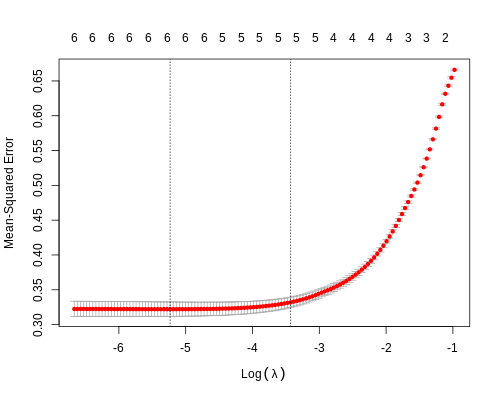

In [ ]:
%%R -w 500 -h 400 -u px
plot(lasso.cv)

In [ ]:
%%R
# Choose lambda with standard error of the minimum
lasso.cv$lambda.1se

[1] 0.03244038


#### Fit a lasso regression

Now Fit the final model with the best "lambda":

In [ ]:
%%R
# fit lasso regression
lasso.fit <-  glmnet(x= x.train,
                       y= y.train,
                       alpha=1,
                       lambda = lasso.cv$lambda.1se,
                       family = "multinomial",
                       type.multinomial = "grouped",
                       nlambda=200)

In [ ]:
%%R
print(lasso.fit)


Call:  glmnet(x = x.train, y = y.train, family = "multinomial", alpha = 1,      nlambda = 200, lambda = lasso.cv$lambda.1se, type.multinomial = "grouped") 

  Df  %Dev  Lambda
1  4 50.42 0.03244


Finally we will extract the coefficients for the selected $λ$ using `coef()` function:

In [ ]:
%%R
coef(lasso.fit)

$A
6 x 1 sparse Matrix of class "dgCMatrix"
                        s0
                3.65183352
age            -0.11527181
household       0.15408964
position_level  0.06947353
genderMale      0.42949078
absent          .         

$B
6 x 1 sparse Matrix of class "dgCMatrix"
                        s0
                0.21983614
age             0.04498977
household      -0.49079558
position_level -0.05717795
genderMale     -1.00574848
absent          .         

$C
6 x 1 sparse Matrix of class "dgCMatrix"
                        s0
               -3.87166967
age             0.07028204
household       0.33670594
position_level -0.01229558
genderMale      0.57625770
absent          .         



#### Prediction test data

In [ ]:
%%R
# Make predictions on the test data
x.test <- model.matrix(product~., test)[,-1]
# Outcome variable
y.test <-train$product

# Prediction
# Prediction
lasso.pred<-as.data.frame(test$product)
lasso.pred$Class_Pred<-lasso.fit  |>
  predict(newx = x.test, type="class")
lasso.pred <- lasso.pred |>
  dplyr::select("test$product", "Class_Pred") |>
  dplyr::rename(Obs_Class = "test$product") |>
  dplyr::rename(Pred_Class = "Class_Pred")
glimpse(lasso.pred)
# ordering the levels
lasso.pred$Obs_Class  <- ordered(lasso.pred$Obs_Class, levels = c("A", "B", "C"))
lasso.pred $Pred_Class <- ordered(lasso.pred$Pred_Class  , levels = c("A", "B", "C"))

Rows: 438
Columns: 2
$ Obs_Class  <fct> A, A, A, A, A, A, A, A, A, A, A, A, A, A, A, A, A, A, A, A,…
$ Pred_Class <chr[,1]> "A", "B", "A", "A", "B", "A", "A", "A", "A", "A", "A", …


In [ ]:
%%R
# accuracy
mean(lasso.pred$Obs_Class  == lasso.pred$Pred_Class)


[1] 0.7739726


In [ ]:
%%R
# error rate
mean(lasso.pred$Obs_Class != lasso.pred$Pred_Class)


[1] 0.2260274


In [ ]:
%%R
# confusion matrix
table(Actual = lasso.pred$Obs_Class, Predicted =lasso.pred$Pred_Class)

      Predicted
Actual   A   B   C
     A 125  18   6
     B  26 101  11
     C  20  18 113


### Elastic Net Regression

#### Cross Validation of the best Elastic Net regression

In [ ]:
%%R
# Define hyperparameter grid
alphas <- seq(0, 1, by = 0.1)                   # Grid for alpha
lambda_seq <- 10^seq(3, -3, length = 100)       # Grid for lambda

# To store results
results <- data.frame(alpha = numeric(), lambda = numeric(), error = numeric())

# Perform grid search
for (a in alphas) {
  # Fit glmnet model for each alpha
  cv_fit <- cv.glmnet(x.train, y.train, family = "multinomial", alpha = a, lambda = lambda_seq, type.measure = "class")

  # Extract best lambda and error for the current alpha
  best_lambda <- cv_fit$lambda.min
  best_error <- min(cv_fit$cvm)  # Minimum cross-validation error

  # Store results
  results <- rbind(results, data.frame(alpha = a, lambda = best_lambda, error = best_error))
}


# Find the best parameters
best_params <- results[which.min(results$error), ]
print(best_params)

  alpha     lambda     error
2   0.1 0.00231013 0.2247525


####  Fit the final model with optimal parameters


In [ ]:
%%R
# Refit the final model with optimal parameters
enet.fit <- glmnet(x.train, y.train, family = "multinomial", alpha = best_params$alpha, lambda = best_params$lambda)

# View coefficients
print(coef(enet.fit))

$A
6 x 1 sparse Matrix of class "dgCMatrix"
                         s0
                4.699700666
age            -0.166665301
household       0.228786494
position_level  0.261680332
genderMale      0.614902899
absent         -0.007895397

$B
6 x 1 sparse Matrix of class "dgCMatrix"
                        s0
                0.28951435
age             0.06737238
household      -0.69844870
position_level -0.15111152
genderMale     -1.58434184
absent          .         

$C
6 x 1 sparse Matrix of class "dgCMatrix"
                         s0
               -4.989215017
age             0.091022644
household       0.419403184
position_level -0.019721577
genderMale      0.741220510
absent          0.005142852



#### Prediction test data

In [ ]:
%%R
# Make predictions on the test data
x.test <- model.matrix(product~., test)[,-1]
# Outcome variable
y.test <-train$product

# Prediction
enet.pred<-as.data.frame(test$product)
enet.pred$Class_Pred<-enet.fit   |>
  predict(newx = x.test, type="class")
enet.pred <- enet.pred |>
  dplyr::select("test$product", "Class_Pred") |>
  dplyr::rename(Obs_Class = "test$product") |>
  dplyr::rename(Pred_Class = "Class_Pred")
glimpse(enet.pred)
# ordering the levels
enet.pred$Obs_Class  <- ordered(enet.pred$Obs_Class, levels = c("A", "B", "C"))
enet.pred $Pred_Class <- ordered(enet.pred$Pred_Class  , levels = c("A", "B", "C"))


Rows: 438
Columns: 2
$ Obs_Class  <fct> A, A, A, A, A, A, A, A, A, A, A, A, A, A, A, A, A, A, A, A,…
$ Pred_Class <chr[,1]> "A", "B", "A", "B", "B", "A", "C", "A", "A", "A", "A", …


In [ ]:
%%R
# accuracy
mean(enet.pred$Obs_Class  == enet.pred$Pred_Class)

[1] 0.760274


In [ ]:
%%R
# error rate
mean(enet.pred$Obs_Class != enet.pred$Pred_Class)

[1] 0.239726


In [ ]:
%%R
# confusion matrix
table(Actual = enet.pred$Obs_Class, Predicted =enet.pred$Pred_Class)

      Predicted
Actual   A   B   C
     A 119  20  10
     B  25 102  11
     C  19  20 112


## Summary and Conclusion

In this tutorial, we explored regularized multinomial logistic regression in R, focusing on both the manual implementation and using the efficient {glmnet} package. We began by understanding the fundamentals of multinomial logistic regression, a model used for predicting categorical outcomes with more than two classes. Recognizing that overfitting can be a significant issue in high-dimensional or small datasets, we introduced regularization techniques, specifically Ridge (L2) and Lasso (L1) regression, which add penalty terms to the model to prevent overfitting and improve generalization. This process may entail parameter tuning through grid search, facilitated by the {caret} or {h2o} packages (please refer to the Machine Learning chapter).

## References

1. [Multinomial Regression](https://glmnet.stanford.edu/articles/glmnet.html)

2. [Multinomial Logistic Regression | Stata Data Analysis Examples](https://stats.oarc.ucla.edu/stata/dae/multinomiallogistic-regression/)

3. [Multinomial Logistic Regression](https://www.sciencedirect.com/topics/mathematics/multinomial-logistic-regression)

4. [Multinomial Regression- Overview](https://www3.nd.edu/~rwilliam/stats3/mlogit1.pdf)